In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import surprise
from surprise import SVD
from surprise import accuracy
from surprise import KNNBasic, KNNWithMeans, KNNBaseline
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import  Dataset
from surprise.model_selection import cross_validate,GridSearchCV
import re
import random  

In [3]:
!pip install surprise

     |████████████████████████████████| 11.8MB 5.5MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670910 sha256=462cb4fce87e09c498979124f99ea91fa4e6c887f77c3c2f86719b69b9edeeff
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [5]:
movie_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/movie_lens/movie.csv')
rating_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/movie_lens/rating.csv')
link_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/movie_lens/link.csv')
tag_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/movie_lens/tag.csv')
genome_tags_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/movie_lens/genome_tags.csv')
genome_scores_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/movie_lens/genome_scores.csv')

In [6]:
movie_df = pd.concat([movie_df,link_df],axis=1)
movie_df = movie_df.loc[:,~movie_df.columns.duplicated()]

In [7]:
movie_df.head(5)

,movieId,title,genres,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0
4,5,Father of the Bride Part II (1995),Comedy,113041,11862.0


### Cleaning Data


In [8]:
#function returns a small sample of rating and movie data combined (5 million data)
def movie_rating_sample_data(movie_df,rating_df):
  movie_rating_combined = pd.merge(movie_df,rating_df,on='movieId')
  combined_small = movie_rating_combined.iloc[:5000000]
  return combined_small

In [9]:
#function to remove rating counts less than 1000
def filter_less_thrsh(combined_small,thresh = 1000):
  combined_small = combined_small[combined_small.groupby('title').rating.transform('count')>thresh]
  return combined_small

In [10]:
#function to remove and rename columns
def remove_rename(combined_small):
  combined_small = combined_small[['userId','movieId','rating']]
  combined_small = combined_small.rename(columns={'userId':'user','movieId':'item',})
  return combined_small

In [11]:
combined_small = movie_rating_sample_data(movie_df,rating_df)
combined_small = filter_less_thrsh(combined_small)

In [12]:
#lets check our data
combined_small.head(5)

,movieId,title,genres,imdbId,tmdbId,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,3,4.0,1999-12-11 13:36:47
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,6,5.0,1997-03-13 17:50:52
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,8,4.0,1996-06-05 13:37:51
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,10,4.0,1999-11-25 02:44:47
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,11,4.5,2009-01-02 01:13:41


### EDA

In [13]:
#function returns number of ratings per movie
def movie_info_count(combined_small):
  #movie rating count
  movie_rating_count = combined_small.groupby('title')['rating'].count().sort_values(ascending=False)

  #unique movie length
  movie_length = len(combined_small['title'].unique())
  print("movi rating count:\n")
  print(movie_rating_count)
  print('-----'*20)
  print('length of unique movies: ',movie_length)

In [14]:
#function to plot important information
def plot_info(combined_small):  
  #plot number of users per rating
  combined_small.groupby('rating').count()['userId'].plot.bar(figsize=(12,8))
  plt.show()
  #plot average rating for a title
  combined_small.groupby('title').mean()['rating'].plot.bar(figsize=(12,8))
  plt.show()
  #plot 

In [15]:
movie_info_count(combined_small)

movi rating count:

title
Pulp Fiction (1994)                      67310
Forrest Gump (1994)                      66172
Shawshank Redemption, The (1994)         63366
Silence of the Lambs, The (1991)         63299
Jurassic Park (1993)                     59715
                                         ...  
Geronimo: An American Legend (1993)       1054
Cowboy Way, The (1994)                    1054
Unzipped (1995)                           1038
National Lampoon's Senior Trip (1995)     1036
Babysitter, The (1995)                    1014
Name: rating, Length: 504, dtype: int64
----------------------------------------------------------------------------------------------------
length of unique movies:  504


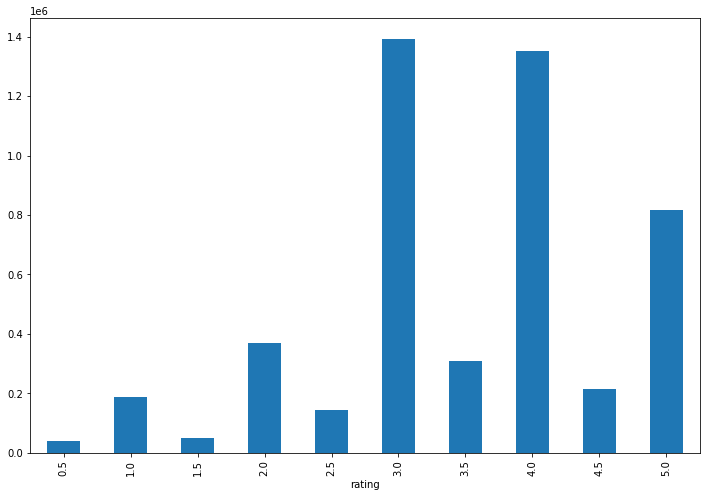

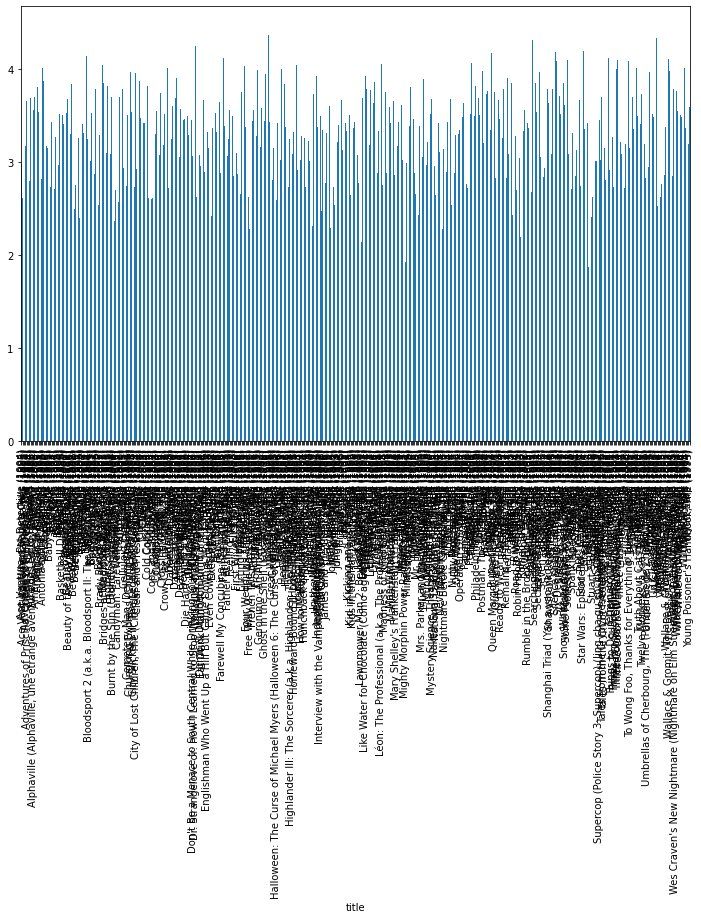

In [16]:
plot_info(combined_small)

## Building Collaborative filtering

In [17]:
print(len(combined_small['title'].unique()))

504


In [18]:
#remove columns and rename them
combined_small = remove_rename(combined_small)

In [19]:
#combined_small.drop(['genres','title'],inplace=True,axis=1)
combined_small.head(5)

,user,item,rating
0,3,1,4.0
1,6,1,5.0
2,8,1,4.0
3,10,1,4.0
4,11,1,4.5


In [20]:
#combined_small.to_csv('/content/drive/MyDrive/Colab Notebooks/movie_lens/combined_small.csv')

In [48]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(combined_small, reader)
raw_ratings  = data.raw_ratings

#shuffle ratings
random.shuffle(raw_ratings)

#90% trainset, 10% testset
threshold = int(.9 * len(raw_ratings))
trainset_raw_ratings = raw_ratings[:threshold]
test_raw_ratings = raw_ratings[threshold:]

data.raw_ratings = trainset_raw_ratings #data is your trainset

#selecting algorithm and grid search
print('grid search ....')

param_grid = {
    'n_epochs':[5,10,25],
    'lr_all':[0.1,0.5,0.8]
}
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse','mae'], joblib_verbose=2)
grid_search.fit(data)
algo = grid_search.best_estimator['rmse']


grid search ....


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 124.4min finished


In [49]:
# retrain on the whole train set                                           
trainset = data.build_full_trainset()                                      
algo.fit(trainset)  
# now test on the testset                                                  
testset = data.construct_testset(test_raw_ratings)                         
predictions = algo.test(testset)                                           
print('Accuracy on the testset:')                                          
print(accuracy.rmse(predictions))
surprise.dump.dump('/content/drive/MyDrive/Colab Notebooks/movie_lens/my_model_v2',predictions=predictions)  

Accuracy on the testset:
RMSE: 0.9390
0.9390372300333313


In [50]:
predictions[1]

Prediction(uid=115843, iid=153, r_ui=4.0, est=2.8636402249476167, details={'was_impossible': False})

### Checking accuracy and predicting

In [51]:
def string_preprocess(row):
  text = row
  text = str(text)
  text = re.sub(r'\(\d+\)', '', text)
  text = text.lower()
  return text

In [52]:
# check the accuracy using Root Mean Square Error
accuracy.rmse(predictions)

RMSE: 0.9390


0.9390372300333313

In [53]:
#movie_rating cropped
movie_rating_combined = pd.merge(movie_df,rating_df,on='movieId')
movie_info_small = movie_rating_combined.iloc[:5000000]

In [54]:
movie_info_small.head(3)

,movieId,title,genres,imdbId,tmdbId,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,3,4.0,1999-12-11 13:36:47
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,6,5.0,1997-03-13 17:50:52
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,8,4.0,1996-06-05 13:37:51


In [55]:
movie_info_small['title'] = movie_info_small['title'].apply(string_preprocess)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [56]:
#create index item name and value item id series
movies_list_id = pd.Series(movie_info_small['movieId'].unique(),index=movie_info_small['title'].unique())

In [57]:
movies_list_id

toy story                         1
jumanji                           2
grumpier old men                  3
waiting to exhale                 4
father of the bride part ii       5
                               ... 
philadelphia story, the         898
singin' in the rain             899
american in paris, an           900
funny face                      901
breakfast at tiffany's          902
Length: 886, dtype: int64

In [65]:
movies_list_id.loc[movies_list_id == 200]

tie that binds, the     200
dtype: int64

In [59]:
def get_movies_recommendation(movie_name):
  movie_name = movie_name.lower()
  item_id = []
  movie_id = movies_list_id.loc[movies_list_id.index.str.contains(movie_name)][0]
  user_id = combined_small.loc[combined_small.item == movie_id]['user'].tolist()[:5]
  for id in user_id:
    for i in range(len(predictions)):
      if predictions[i].uid == id:
        item_id.append(predictions[i].iid)
  movies_names = movies_list_id.loc[movies_list_id.isin(item_id)].index.tolist()[:5]
  for names in movies_names:
    if names.strip() == movie_name:
      movies_names.remove(names)
      movies_names.append(movies_list_id.loc[movies_list_id.isin(item_id)].index.tolist()[6])
  return movies_names

In [1]:
get_movies_recommendation("city of lost children")

NameError: ignored